<h1>Project summary</h1>

The topic of this project is recruitment made by a data science company. 

The dataset includes more than 19 000 entries. The analysis includes an <b>extensive EDA</b> and implementation of few machine learning algorithms with <b>accuracy around 0.73</b>. The nature of the dataset resulted in requirement of <b>massive data engineering</b> using different probability distributions.

This research may bring <b>extremely valuable insights for a (not only) data science company</b>, as taking the findings of this analysis into consideration <b>may result in cutting down both time and money cost</b> of each new recruit.

The best performing model was Random Forest. Other models have been tried, for instance Histogram Gradient Boosting or Logistic Regression.

<h1>Project outline</h1>
    
    • State the initial hypotheses
    • Make necessary imports, take first look at the dataset, identify variables
    • Engineer missing data in both continuous and categorical columns
    • Univariate analysis
    • Multivariate analysis (mainly in relation to training hours)
    • Multivariate analysis in relation to target variable
    • Correlation inspection
    • Model set-up, skewness handling
    • Model implementation

<h2>Hypotheses and notes</h2>
    
    • Trainees with more trained hours who do not enroll in the end are extremely costly 
        • Training hours is almost as important as the target variable
    • City column in excessive since city development index holds much more information
    • City development index may be positively correlated with target variable and relevant experience as Data Science is a rather modern field
    • Gender may be correlated to target variable and relevant experience
        • Are genders equal in the field of data science?
    • Relevant experience should have a huge impact on both training hours and target variable
        • Same might go for general experience
    • People with STEM Major may be more likely to pursue career in the data science field
    • People with higher education level are likely to require less training hours
    • Training hours and target are unlikely to be very correlated
    
    • Note: Among the features of the dataset are many variables whose analysis could be very interesting but
            would not be related to the purpose of this project (such examples include gender vs. enrolled university etc.)

In [2]:
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?fbclid=IwAR2jKFzfv2xK7Uj8FQfnSHEicbpMFl0yAJHRLBRZfq98Xcy2dEz9W2bZAy8

<h2>Necessary imports, first looks at the dataset</h2>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option("max_columns", 20)
sb.set_style("whitegrid", {"grid.color": ".78"})
sb.set_palette("deep")
cmap = sb.diverging_palette(240, 25, as_cmap=True)

In [4]:
from sklearn.preprocessing import scale
from scipy.stats import norm, skew, boxcox

from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import statsmodels.discrete.discrete_model as sm

In [153]:
df = pd.read_csv("Job_change_train.csv")
df_test = pd.read_csv("Job_change_test.csv")
df_test["target"] = pd.Series(np.load("jobchange_test_target_values.npy"))

In [6]:
df.drop("enrollee_id", axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


In [8]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [9]:
df["relevent_experience"].replace({"Has relevent experience": "Has relevant experience", 
                                   "No relevent experience": "No relevant experience"}, inplace=True)

In [10]:
#Check the numeric variables, check for outliers, check mean and median, max and min values
pd.concat([df.describe().T, df.median().rename("median")], axis=1).T

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000
median,0.903000,47.000000,0.000000


<h2>Variable identification</h2>

In [11]:
#Target variable - "target" - whether the candidate will change the job or not (binary categorical)
#Data types - numeric and text (often text hiding a numeric value)
#Variable category
    #Categorical:
        #city, gender, relevent_experience, enrolled_university, 
        #education_level, major_discipline, company_type
    #Continuous:
        #city_development_index, training_hours, experience, company_size, last_new_job

            
#Correlated variables:
    #city - city_development_index
        #The city development index gives us more information and less bias, therefore, 
        #the column city will be dropped
    #enrolled_university - education_level
        #Since education level preserves more information at the cost of university enrollment details,
        #the column enrolled_university will be dropped
    #education_level - major_discipline
        #Only those, who have been to university, do have some major discipline
    
#Likely to be correlated variables:
    #city_development_index - relevent_experience
    #gender - relevent_experience
    #relevent_experience - training_hours
    #major_discipline - training_hours
    #experience - training_hours
    #Few others, whose analysis, however, is not the purpose of the project

In [12]:
df.drop(columns=["city", "enrolled_university"], inplace=True)

<h2>Data Engineering</h2>

In [151]:
# In order to be able to asess correlation of continuous variables
# which have been given in some categorical form (>20 and >4),
# these values will be replaced using exponential distribution
# and with edge values of 40 for experience and 8 for last new job (double the current edge)
    # This approach has been chosen as we can see the falling off trend in the experience column,
    # thus the above method should reflect the reality quite well despite not having access to the data
    # The edges will be achieved by resampling values >40 / >8
        # Computationally heavy - not really after shifting the distribution by 21 or 5, respectively
# Also, the values "never" and "<1" will be replaced by 0.01, which seems quite justified
    # 0.01 has been chosen over 0, because later on we try to resolve skewness and for that we need positive entires

# This will definitely add a bias to the data, the impact should, however, be quite small

In [14]:
def exp_d(x, col):
    if col == "experience":
        if x == 21:
            a = np.random.exponential(scale=4) + 21
            while a > 40:
                a = np.random.exponential(scale=4) + 21
            return round(a)
        else:
            return x
    elif col == "last_new_job":
        if x == 5:
            a = np.random.exponential(scale=1) + 5
            while a > 8:
                a = np.random.exponential(scale=1) + 5
            return round(a)
        else:
            return x
    else:
        raise ValueError("What column")

In [15]:
df["experience"] = df["experience"].replace({"<1": 0.01, ">20": 21}).astype("float").apply(exp_d, args=("experience",))
df["last_new_job"] = df["last_new_job"].replace({"never": 0.01, ">4": 5}).astype("float").apply(exp_d, args=("last_new_job",))

In [16]:
# Similar approach will be used for the extreme categories in the column "company_size"
    # The lowest category (<10) will be filled with reversed exponential distribution
# The non-extreme categories will be filled using uniform distribution, as there is no reason
# to assume some major trend towards the edges
    # Alternative approach would be using the normal distribution (since all distributions converge)
    
# Afterwards, the NaN values of this column will be filled since
# this column is the one with the most missing values amongst the continuous columns
    # This will be achieved using normal distribution around the mean value and cut in 1,
    # therefore achieving the exact same right-skewness as is presented in the distribution of the column values

def exp_d_c_size(x):
    if x == "<10":
        a = -np.random.exponential(scale=1) + 10
        while a < 1:
            a = -np.random.exponential(scale=1) + 10
        return round(a)
    elif x in ["10-49", "50-99", "100-500", "500-999", "1000-4999", "5000-9999"]:
        bounds = x.split("-")
        return round(np.random.uniform(int(bounds[0]), int(bounds[1])))
    elif x == "10000+":
        a = np.random.exponential(scale=2000) + 10000
        while a > 20000:
            a = np.random.exponential(scale=2000) + 10000
        return round(a)
    else:
        if np.isnan(x):
            return x
        else:
            print(x)
            raise ValueError("Something went wrong")
            
def fill_na_c_size(x, m):
    if np.isnan(x):
        a = np.random.normal(loc=m, scale=2000)
        while a < 1:
            a = np.random.normal(loc=m, scale=2000)
        return round(a)
    else:
        return x

In [17]:
df["company_size"] = df["company_size"].replace({"10/49": "10-49"}).apply(exp_d_c_size)
m = df["company_size"].mean()
df["company_size"] = df["company_size"].apply(fill_na_c_size, args=(m, ))

In [18]:
# Gender, Major and company type are three of the categorical variables with the most missing values
# Therefore, these values will be filled in order to have a bigger sample size
    # This will make our analysis more based on the data and should improve our model accuraccy
    # On the other hand, this could also add a considerable bias to the data
# Firstly, major will be filled with "No university" for people who have not reached university education
# Afterwards, all variables will be filled accordingly to their distributions
    # Meaning that if 50 % of the participants were men, then 50 % of the missing values will be filled with men

In [19]:
def map_func(x):
    if x in ["High School", "Primary School"]:
        return "No university"
    else:
        return np.NaN

In [20]:
df.loc[df["major_discipline"].isnull(), "major_discipline"] = df.loc[df["major_discipline"].isnull(), "education_level"].apply(map_func)

In [21]:
def find_dist(col):
    vc = col.value_counts(normalize=True)
    d = {}
    for i in range(len(vc)):
        d[vc.index[i]] = vc[i]
    return d

def fill_cat(x, dist):
    fillers = list(dist.keys())
    probabilities = list(dist.values())
    if np.isnan(x):
        return np.random.choice(fillers, p=probabilities)
    else:
        print(x)
        raise ValueError("Something went wrong")

In [22]:
gender_dist = find_dist(df["gender"])
comp_type_dist = find_dist(df["company_type"])

df.loc[df["gender"].isnull(), "gender"] = df.loc[df["gender"].isnull(), "gender"].apply(fill_cat, args=(gender_dist, ))
df.loc[df["company_type"].isnull(), "company_type"] = df.loc[df["company_type"].isnull(), "company_type"].apply(fill_cat, args=(comp_type_dist, ))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   gender                  19158 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   education_level         18698 non-null  object 
 4   major_discipline        18670 non-null  object 
 5   experience              19093 non-null  float64
 6   company_size            19158 non-null  float64
 7   company_type            19158 non-null  object 
 8   last_new_job            18735 non-null  float64
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 1.6+ MB


In [24]:
# Now it is way more justified to drop the rows with missing entries than before
# (Does not result in losing almost half the dataset)

df.dropna(inplace=True)

<h2>Univariate Analysis</h2>

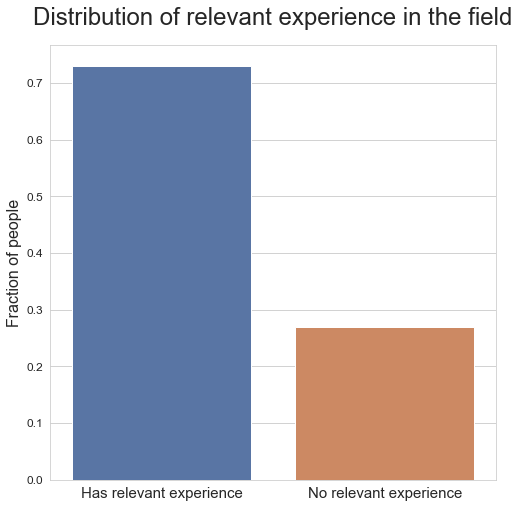

In [25]:
frequency = df["relevent_experience"].fillna("DNA").value_counts(normalize=True)

plt.figure(figsize=(8, 8))
sb.barplot(x=frequency.index, y=frequency)

plt.title("Distribution of relevant experience in the field", fontsize=24, pad=20)
plt.xticks(fontsize=15)
plt.ylabel("Fraction of people", fontsize=16)
plt.yticks(fontsize=12)

plt.show()

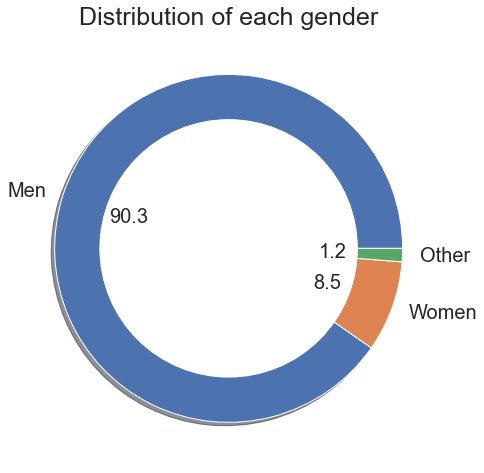

In [26]:
genders = ["Men", "Women", "Other"]
sizes = df["gender"].value_counts(normalize=True)

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, labels=genders, shadow=True, textprops={"size": 20}, autopct="%.1f")
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.74, color="white"))
plt.title("Distribution of each gender", fontsize=25)

plt.show()

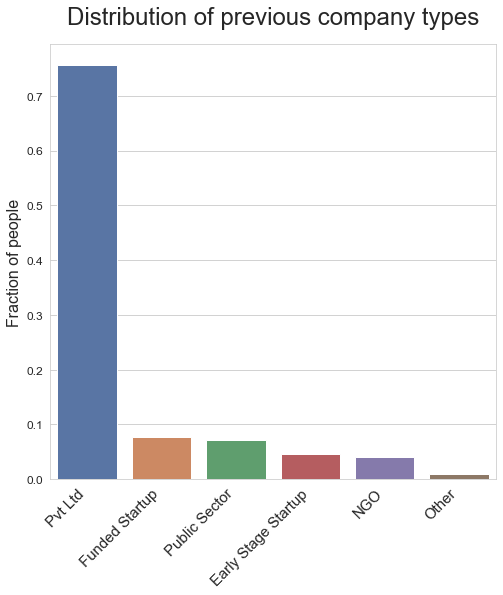

In [27]:
frequency = df["company_type"].fillna("DNA").value_counts(normalize=True)

plt.figure(figsize=(8, 8))
sb.barplot(x=frequency.index, y=frequency)

plt.title("Distribution of previous company types", fontsize=24, pad=20)
plt.xticks(fontsize=15, rotation=45, ha="right")
plt.ylabel("Fraction of people", fontsize=16)
plt.yticks(fontsize=12)

plt.show()

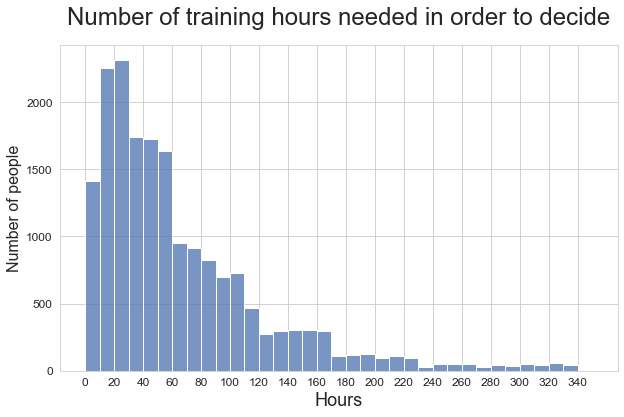

In [28]:
plt.figure(figsize=(10, 6))
sb.histplot(data=df["training_hours"].dropna(), binwidth=10, binrange=(0, 350))

plt.title("Number of training hours needed in order to decide", fontsize=24, pad=20)
plt.xlabel("Hours", fontsize=18)
plt.xticks([i for i in range(0, 351, 20)], fontsize=12)
plt.ylabel("Number of people", fontsize=16)
plt.yticks(fontsize=12)

plt.show()

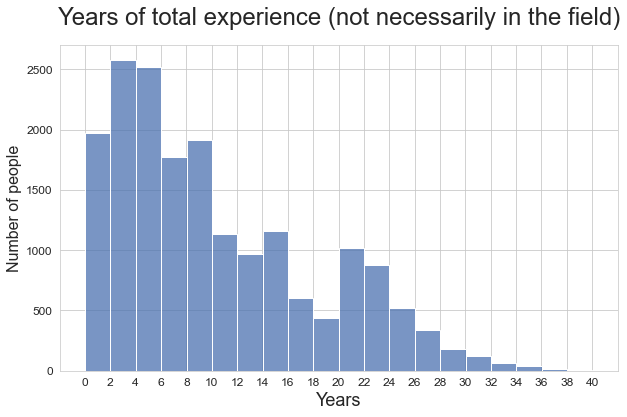

In [29]:
plt.figure(figsize=(10, 6))
sb.histplot(data=df["experience"], binwidth=2)

plt.title("Years of total experience (not necessarily in the field)", fontsize=24, pad=20)
plt.xlabel("Years", fontsize=18)
plt.xticks(range(0, 41, 2), fontsize=12)
plt.ylabel("Number of people", fontsize=16)
plt.yticks(fontsize=12)

plt.show()

<h2>Bivariate and Multivariate Analysis (Target excluded)</h2>

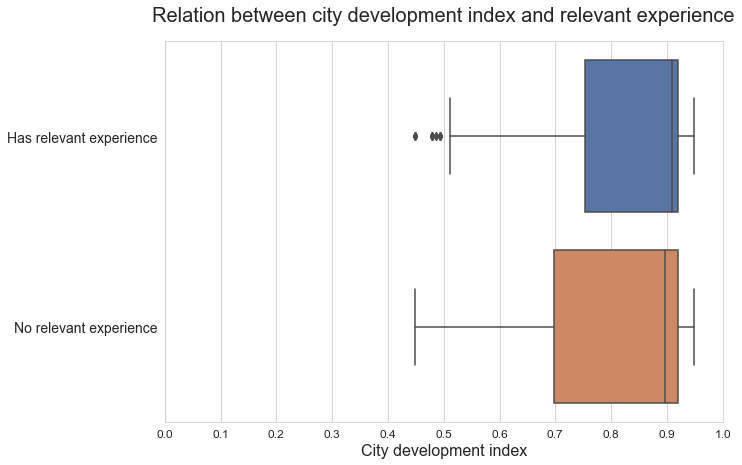

In [31]:
plt.figure(figsize=(10, 7))
sb.boxplot(y=df["relevent_experience"], x=df["city_development_index"], orient = "h")

plt.title("Relation between city development index and relevant experience", fontsize=20, pad=20)
plt.xlabel("City development index", fontsize=16)
plt.xticks(ticks=np.arange(0, 1.1, 0.1), fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=14)

plt.show()

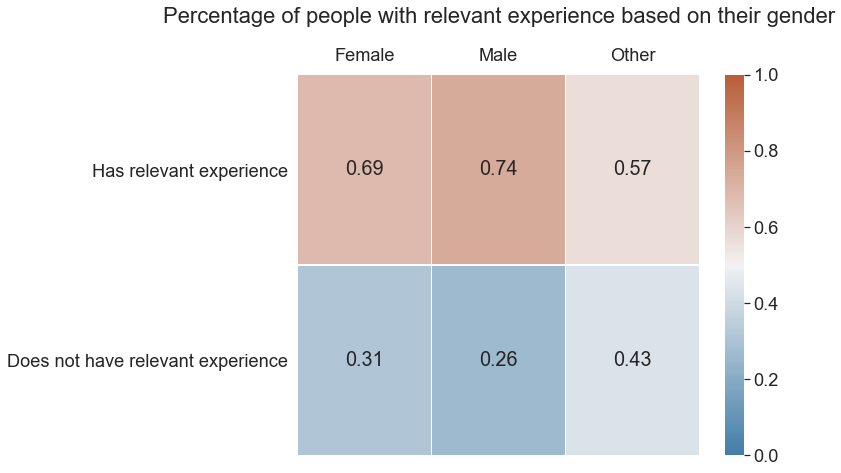

In [32]:
plt.figure(figsize=(9, 7))
sb.set(font_scale=1.65)
sb.heatmap(pd.DataFrame(df.groupby("gender").relevent_experience.value_counts(normalize=True)).unstack(level=1).T,
           vmin=0, vmax=1, annot=True, linewidth=0.4, cmap=cmap,
           xticklabels=["Female", "Male", "Other"], 
           yticklabels=["Has relevant experience", "Does not have relevant experience"])

plt.title("Percentage of people with relevant experience based on their gender", fontsize=22, pad=25)
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelbottom=False, labeltop=True)

plt.show()

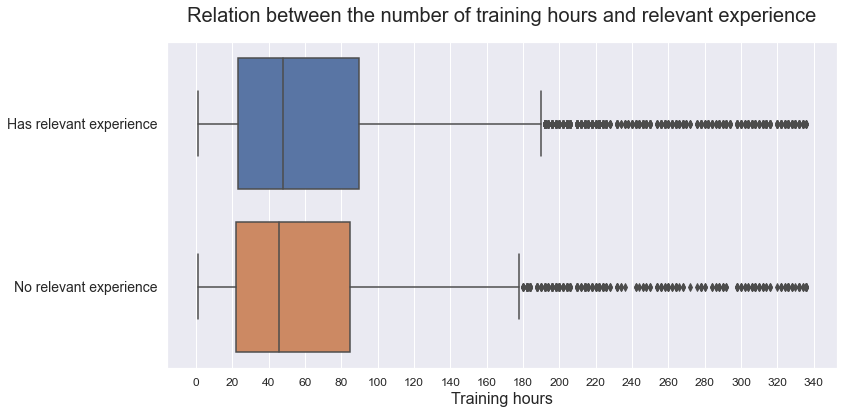

In [33]:
plt.figure(figsize=(12, 6))
sb.boxplot(y=df["relevent_experience"], x=df["training_hours"], orient = "h")

plt.title("Relation between the number of training hours and relevant experience", fontsize=20, pad=20)
plt.xlabel("Training hours", fontsize=16)
plt.xticks(ticks=range(0, 350, 20), fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=14)

plt.show()

In [34]:
pd.DataFrame(df.groupby("education_level").major_discipline.value_counts())

major_discipline
education_level major_discipline                  
Graduate        STEM                         10018
                Humanities                     417
                Other                          264
                Business Degree                237
                Arts                           205
                No Major                       187
High School     No university                 1951
Masters         STEM                          3801
                Humanities                     221
                Other                           96
                Business Degree                 85
                Arts                            42
                No Major                        29
Phd             STEM                           368
                Humanities                      24
                Other                            8
                Arts                             3
                Business Degree                  2
Primary School  No university                  299

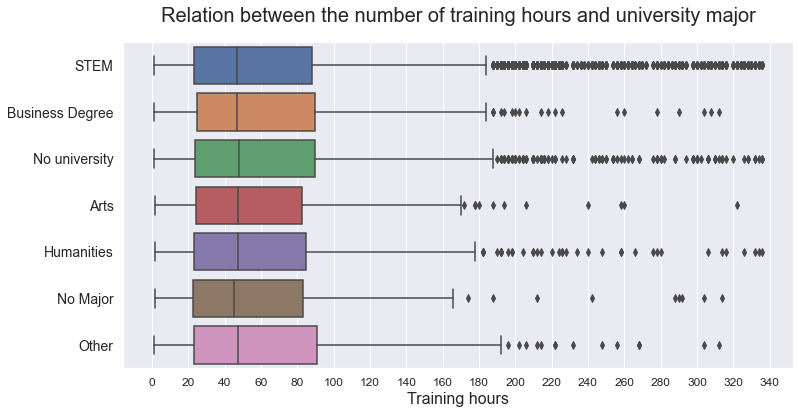

In [35]:
plt.figure(figsize=(12, 6))
sb.boxplot(y=df["major_discipline"], x=df["training_hours"], orient = "h")

plt.title("Relation between the number of training hours and university major", fontsize=20, pad=20)
plt.xlabel("Training hours", fontsize=16)
plt.xticks(ticks=range(0, 350, 20), fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=14)

plt.show()

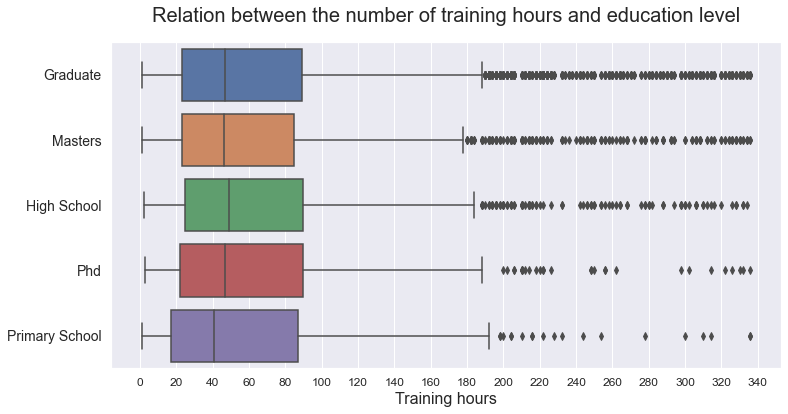

In [36]:
plt.figure(figsize=(12, 6))
sb.boxplot(y=df["education_level"], x=df["training_hours"], orient = "h")

plt.title("Relation between the number of training hours and education level", fontsize=20, pad=20)
plt.xlabel("Training hours", fontsize=16)
plt.xticks(ticks=range(0, 350, 20), fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=14)

plt.show()

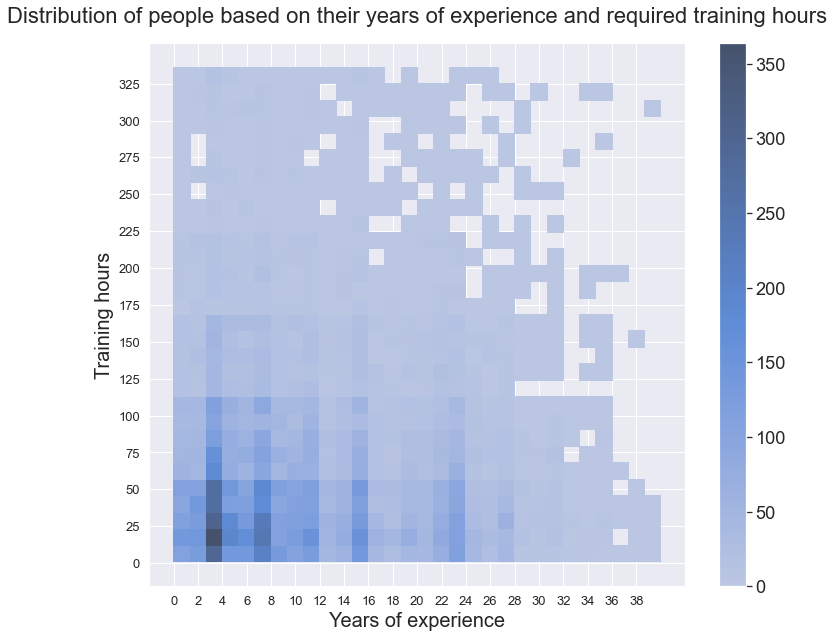

In [37]:
plt.figure(figsize=(12, 10))
sb.histplot(data=df, x="experience", y="training_hours", bins=30, cbar=True)

plt.title("Distribution of people based on their years of experience and required training hours", fontsize=22, pad=20)
plt.xlabel("Years of experience", fontsize=20)
plt.xticks(range(0, 40, 2), fontsize=13)
plt.ylabel("Training hours", fontsize=20)
plt.yticks(range(0, 350, 25), fontsize=13)

plt.show()

In [38]:
df.groupby(["relevent_experience", "education_level"]).training_hours.agg(["mean", "count"])

mean  count
relevent_experience     education_level                  
Has relevant experience Graduate         66.750000   8740
                        High School      66.608355    766
                        Masters          63.658120   3510
                        Phd              70.374016    254
                        Primary School   56.734375     64
No relevant experience  Graduate         62.980294   2588
                        High School      67.085232   1185
                        Masters          61.189791    764
                        Phd              64.960265    151
                        Primary School   65.497872    235

In [39]:
df.groupby(["education_level", "major_discipline"]).training_hours.agg(["mean", "count"])

mean  count
education_level major_discipline                  
Graduate        Arts              60.775610    205
                Business Degree   67.177215    237
                Humanities        66.139089    417
                No Major          64.727273    187
                Other             68.443182    264
                STEM              65.906868  10018
High School     No university     66.898001   1951
Masters         Arts              59.714286     42
                Business Degree   64.105882     85
                Humanities        64.950226    221
                No Major          53.068966     29
                Other             57.916667     96
                STEM              63.346225   3801
Phd             Arts              42.333333      3
                Business Degree   69.000000      2
                Humanities        66.833333     24
                Other             48.000000      8
                STEM              69.105978    368
Primary School  No university     63.622074    299

<h2>Target Relations Analysis</h2>

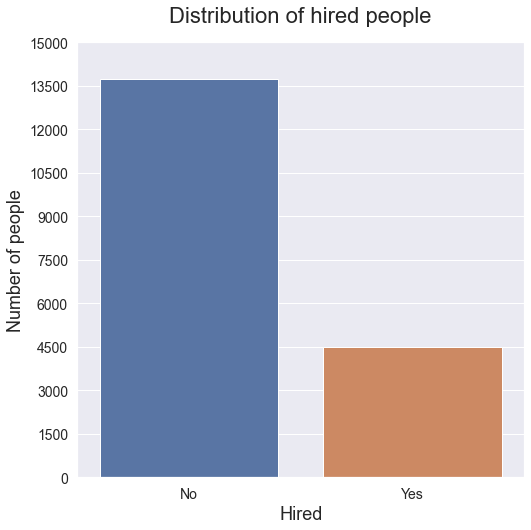

In [40]:
frequency = df["target"].replace({1: "Yes", 0: "No"}).value_counts()

plt.figure(figsize=(8, 8))
sb.barplot(x=frequency.index, y=frequency)

plt.title("Distribution of hired people", fontsize=22, pad=20)
plt.xlabel("Hired", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Number of people", fontsize=18)
plt.yticks(range(0, 15001, 1500), fontsize=14)

plt.show()

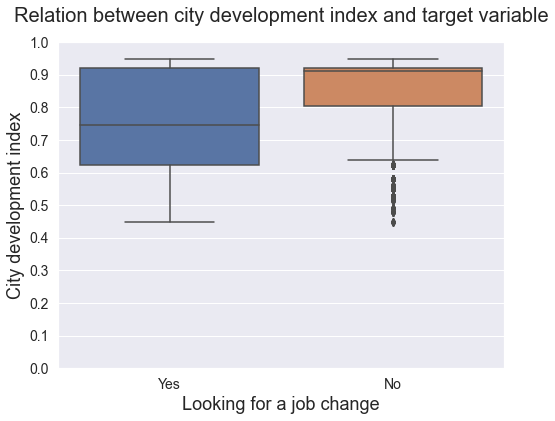

In [42]:
plt.figure(figsize=(8, 6))
sb.boxplot(y=df["city_development_index"], x=df["target"].replace({1: "Yes", 0: "No"}), orient="v")

plt.title("Relation between city development index and target variable", fontsize=20, pad=20)
plt.xlabel("Looking for a job change", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("City development index", fontsize=18)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)

plt.show()

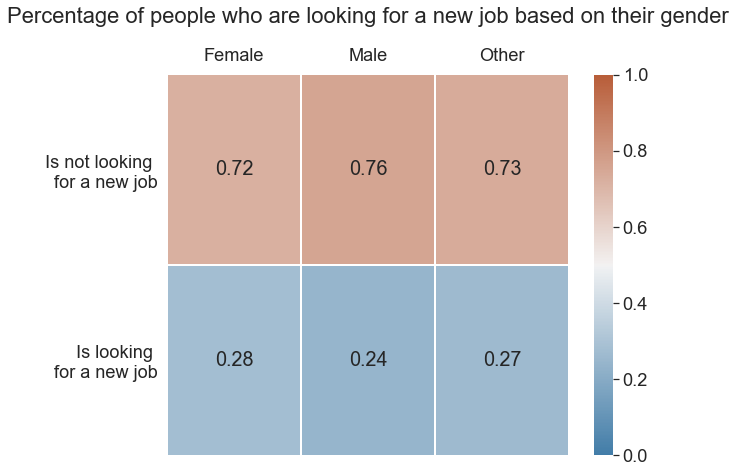

In [43]:
plt.figure(figsize=(9, 7))
sb.set(font_scale=1.65)
sb.heatmap(pd.DataFrame(df.groupby("gender").target.value_counts(normalize=True)).unstack(level=1).T,
           vmin=0, vmax=1, annot=True, linewidth=0.4, cmap=cmap,
           xticklabels=["Female", "Male", "Other"], 
           yticklabels=["Is not looking \n for a new job", "Is looking \n for a new job"])

plt.title("Percentage of people who are looking for a new job based on their gender", fontsize=22, pad=25)
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="both", labelbottom=False, labeltop=True, rotation=0)

plt.show()

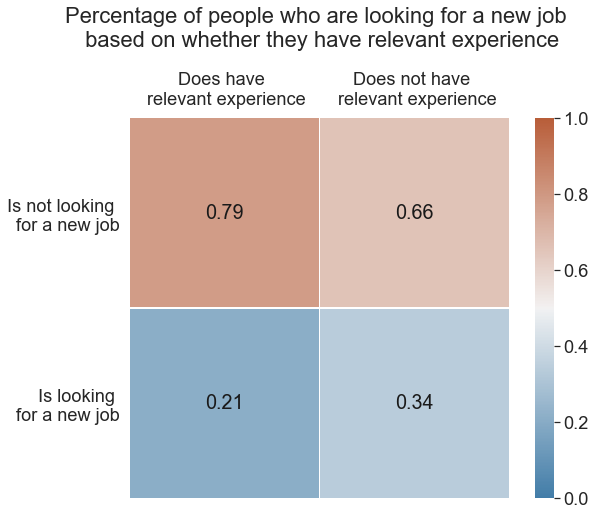

In [44]:
plt.figure(figsize=(9, 7))
sb.set(font_scale=1.65)
sb.heatmap(pd.DataFrame(df.groupby("relevent_experience").target.value_counts(normalize=True)).unstack(level=1).T,
           vmin=0, vmax=1, annot=True, linewidth=0.4, cmap=cmap,
           square=True, annot_kws={"color": "k"},
           xticklabels=["Does have \n relevant experience", "Does not have \n relevant experience"], 
           yticklabels=["Is not looking \n for a new job", "Is looking \n for a new job"])

plt.title("Percentage of people who are looking for a new job \n based on whether they have relevant experience", 
          fontsize=22, pad=25)
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="both", labelbottom=False, labeltop=True, rotation=0)

plt.show()

In [45]:
pd.crosstab(index=df["target"], columns=[df["education_level"]], normalize="columns").T
# Normalizing by index would exaggerate the sample size differences between the education levels

target,0.0,1.0
education_level,,
Graduate,0.723605,0.276395
High School,0.805228,0.194772
Masters,0.788956,0.211044
Phd,0.861728,0.138272
Primary School,0.872910,0.127090


In [46]:
pd.crosstab(index=df["target"], columns=[df["education_level"], df["major_discipline"]], normalize="columns").T
# Normalizing by index would exaggerate the sample size differences between the education levels

target                                 0.0       1.0
education_level major_discipline                    
Graduate        Arts              0.814634  0.185366
                Business Degree   0.729958  0.270042
                Humanities        0.772182  0.227818
                No Major          0.737968  0.262032
                Other             0.704545  0.295455
                STEM              0.719804  0.280196
High School     No university     0.805228  0.194772
Masters         Arts              0.666667  0.333333
                Business Degree   0.752941  0.247059
                Humanities        0.828054  0.171946
                No Major          0.827586  0.172414
                Other             0.833333  0.166667
                STEM              0.787424  0.212576
Phd             Arts              0.666667  0.333333
                Business Degree   1.000000  0.000000
                Humanities        0.833333  0.166667
                Other             1.000000  0.000000
                STEM              0.861413  0.138587
Primary School  No university     0.872910  0.127090

In [47]:
pd.crosstab(index=df["target"], columns=[df["company_type"]], normalize="columns").T
# Normalizing by index would exaggerate the sample size differences between the company types

target,0.0,1.0
company_type,,
Early Stage Startup,0.716687,0.283313
Funded Startup,0.777383,0.222617
NGO,0.753369,0.246631
Other,0.729560,0.270440
Public Sector,0.724715,0.275285
Pvt Ltd,0.755832,0.244168


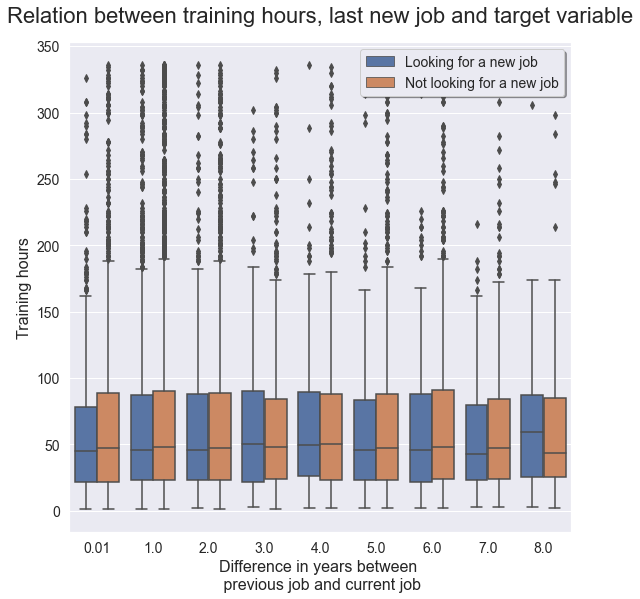

In [48]:
sub_df = df.copy()
sub_df["target"].replace({0: "Not looking for a new job", 1: "Looking for a new job"}, inplace=True)

plt.figure(figsize=(9, 9))
sb.boxplot(data=sub_df, x="last_new_job", y="training_hours", hue="target", orient="v")

plt.title("Relation between training hours, last new job and target variable", fontsize=22, pad=20)
plt.xlabel("Difference in years between \n previous job and current job", fontsize=16)
plt.xticks(range(0, 9), fontsize=14)
plt.ylabel("Training hours", fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc=1, shadow=True, framealpha=1)

plt.show()

In [49]:
df.groupby(["relevent_experience", "education_level", "target"]).training_hours.agg(["mean", "count"])

mean  count
relevent_experience     education_level target                  
Has relevant experience Graduate        0.0     67.356185   6710
                                        1.0     64.746305   2030
                        High School     0.0     66.724036    674
                                        1.0     65.760870     92
                        Masters         0.0     64.662452   2847
                                        1.0     59.345400    663
                        Phd             0.0     70.446429    224
                                        1.0     69.833333     30
                        Primary School  0.0     58.250000     56
                                        1.0     46.125000      8
No relevant experience  Graduate        0.0     63.968393   1487
                                        1.0     61.645777   1101
                        High School     0.0     66.865106    897
                                        1.0     67.770833    288
                        Masters         0.0     61.561905    525
                                        1.0     60.372385    239
                        Phd             0.0     66.744000    125
                                        1.0     56.384615     26
                        Primary School  0.0     67.287805    205
                                        1.0     53.266667     30

In [50]:
df.groupby(["education_level", "major_discipline", "target"]).training_hours.agg(["mean", "count"])

mean  count
education_level major_discipline target                  
Graduate        Arts             0.0     58.143713    167
                                 1.0     72.342105     38
                Business Degree  0.0     64.728324    173
                                 1.0     73.796875     64
                Humanities       0.0     68.596273    322
                                 1.0     57.810526     95
                No Major         0.0     70.528986    138
                                 1.0     48.387755     49
                Other            0.0     70.279570    186
                                 1.0     64.064103     78
                STEM             0.0     66.742477   7211
                                 1.0     63.760242   2807
High School     No university    0.0     66.804583   1571
                                 1.0     67.284211    380
Masters         Arts             0.0     65.214286     28
                                 1.0     48.714286     14
                Business Degree  0.0     65.125000     64
                                 1.0     61.000000     21
                Humanities       0.0     65.415301    183
                                 1.0     62.710526     38
                No Major         0.0     54.916667     24
                                 1.0     44.200000      5
                Other            0.0     57.162500     80
                                 1.0     61.687500     16
                STEM             0.0     64.336118   2993
                                 1.0     59.679455    808
Phd             Arts             0.0     32.500000      2
                                 1.0     62.000000      1
                Business Degree  0.0     69.000000      2
                Humanities       0.0     62.950000     20
                                 1.0     86.250000      4
                Other            0.0     48.000000      8
                STEM             0.0     70.274448    317
                                 1.0     61.843137     51
Primary School  No university    0.0     65.348659    261
                                 1.0     51.763158     38

In [51]:
df.groupby(["target", "company_type"]).training_hours.agg(["mean", "count"])

mean  count
target company_type                         
0.0    Early Stage Startup  66.889447    597
       Funded Startup       67.271729   1093
       NGO                  67.178891    559
       Other                69.750000    116
       Public Sector        62.026233    953
       Pvt Ltd              66.277607  10432
1.0    Early Stage Startup  69.444915    236
       Funded Startup       61.939297    313
       NGO                  64.508197    183
       Other                67.860465     43
       Public Sector        59.627072    362
       Pvt Ltd              62.935905   3370

<h2>Correlation inspection</h2>

In [52]:
df["relevent_experience"] = df["relevent_experience"].replace({"No relevant experience": 0, "Has relevant experience": 1})

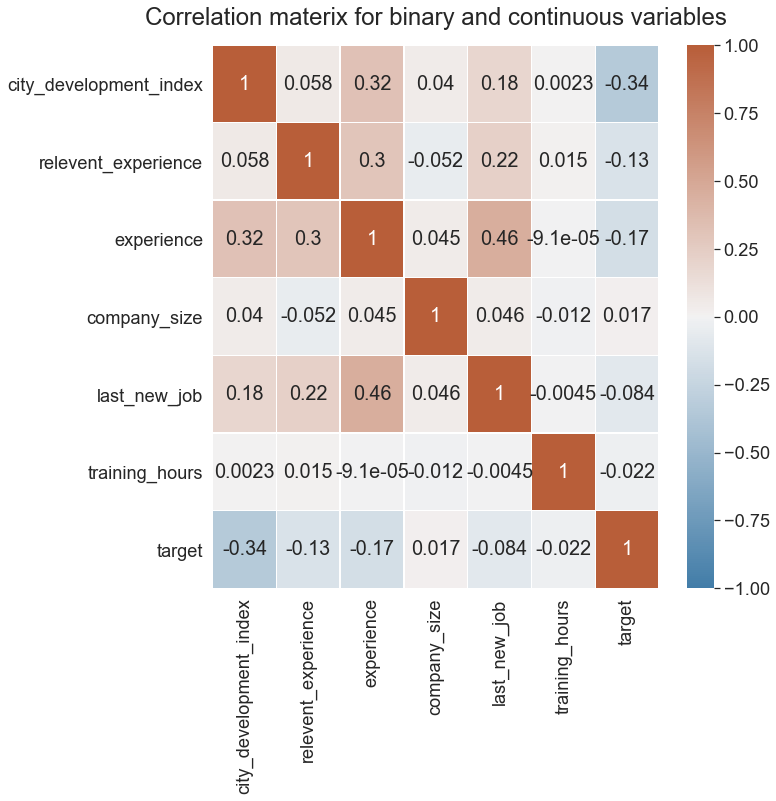

In [53]:
plt.figure(figsize=(10, 10))
sb.set(font_scale=1.65)

sb.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.4, cmap=cmap)

plt.title("Correlation materix for binary and continuous variables", fontsize=24, pad=20)

plt.show()

In [54]:
# In order to be able to fit a model using all the available data and also
# to be able to inspect correlation, some of the categorical variables will be 
# replaced by their respective dummy variables
    # Drop first setting will be used since one of the categories is always extra
        # We do not need to watch out for NaN values anymore after we have filled them accordingly

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18257 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18257 non-null  float64
 1   gender                  18257 non-null  object 
 2   relevent_experience     18257 non-null  int64  
 3   education_level         18257 non-null  object 
 4   major_discipline        18257 non-null  object 
 5   experience              18257 non-null  float64
 6   company_size            18257 non-null  float64
 7   company_type            18257 non-null  object 
 8   last_new_job            18257 non-null  float64
 9   training_hours          18257 non-null  int64  
 10  target                  18257 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 2.3+ MB


In [56]:
df = pd.get_dummies(data=df, drop_first=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18257 entries, 0 to 19157
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   city_development_index            18257 non-null  float64
 1   relevent_experience               18257 non-null  int64  
 2   experience                        18257 non-null  float64
 3   company_size                      18257 non-null  float64
 4   last_new_job                      18257 non-null  float64
 5   training_hours                    18257 non-null  int64  
 6   target                            18257 non-null  float64
 7   gender_Male                       18257 non-null  uint8  
 8   gender_Other                      18257 non-null  uint8  
 9   education_level_High School       18257 non-null  uint8  
 10  education_level_Masters           18257 non-null  uint8  
 11  education_level_Phd               18257 non-null  uint8  
 12  educ

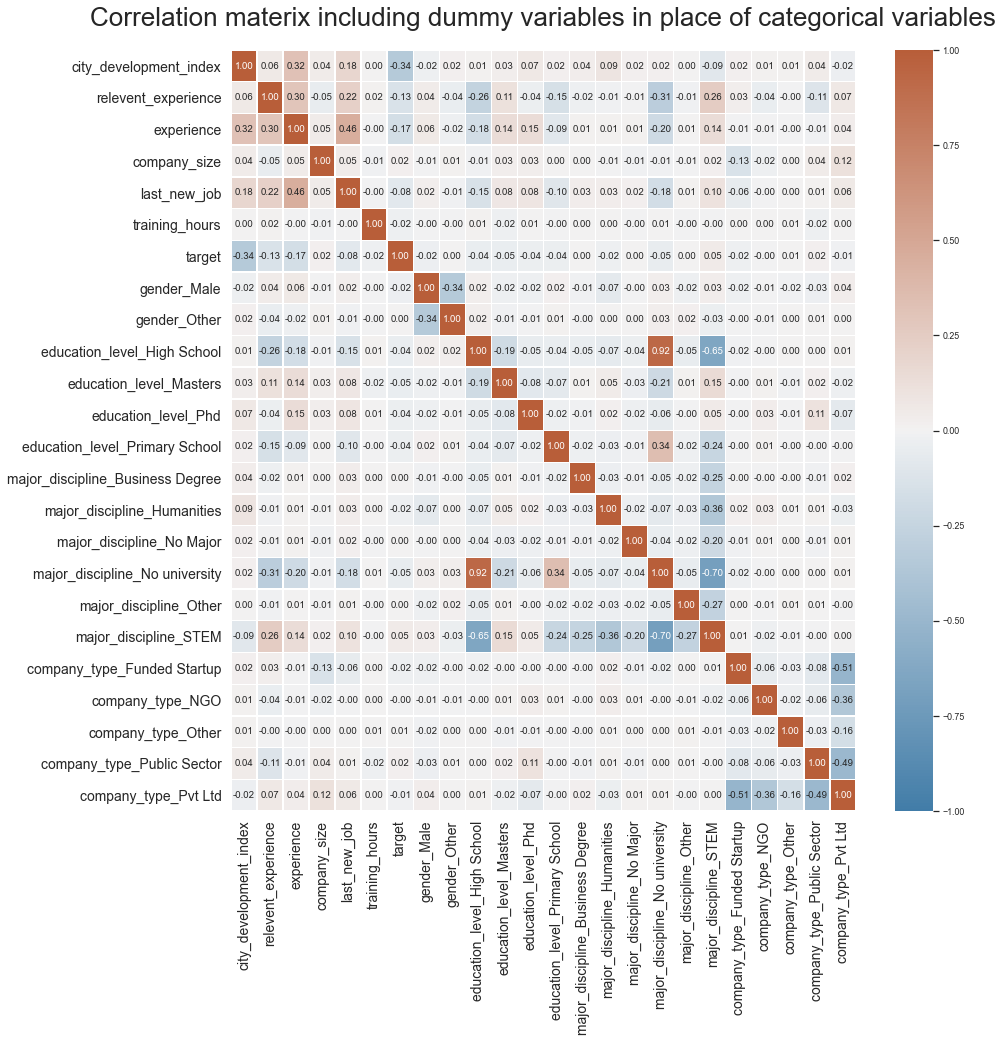

In [58]:
plt.figure(figsize=(14, 14))
sb.set(font_scale=0.8)

sb.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.4, 
           cmap=cmap, fmt=".2f")

plt.title("Correlation materix including dummy variables in place of categorical variables", fontsize=26, pad=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<h2>Modeling setup</h2>

In [59]:
# The continuous variables (namely city development index, experience, company size, last new job and training hours) 
# all show a major level of skewness 
    # This might negatively impact our models, therefore we should preprocess these beforehand

In [60]:
df.agg(["skew"]).T

,skew
city_development_index,-1.029010
relevent_experience,-1.038217
experience,0.806459
company_size,1.701629
last_new_job,1.107212
training_hours,1.818786
target,1.174231
gender_Male,-2.724567
gender_Other,8.820913
education_level_High School,2.545286


city_development_index 
 	 Pre-transformation: mu = 0.8307718683244784, sigma = 0.12246209278343255 
 	 Post-transformation: mu = -0.09568708154933506, sigma = 0.037410315792490816 

experience 
 	 Pre-transformation: mu = 10.893279290135293, sigma = 7.989476260553239 
 	 Post-transformation: mu = 3.755148324844097, sigma = 2.254960733184813 

company_size 
 	 Pre-transformation: mu = 2704.374322177795, sigma = 3797.3261450795962 
 	 Post-transformation: mu = 8.921540192677956, sigma = 3.8570045830578894 

last_new_job 
 	 Pre-transformation: mu = 2.1582231472859723, sigma = 1.9597255481502622 
 	 Post-transformation: mu = 0.48892030974920697, sigma = 1.3623418980536577 

training_hours 
 	 Pre-transformation: mu = 65.38872761132716, sigma = 60.03843422207694 
 	 Post-transformation: mu = 5.452208639995043, sigma = 1.8496793190845355 



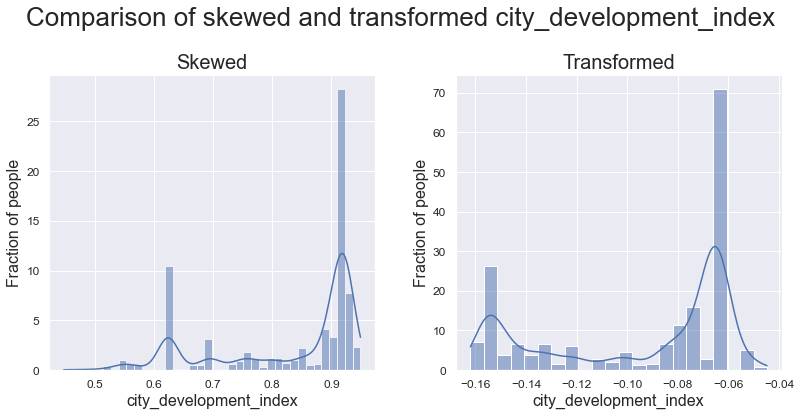

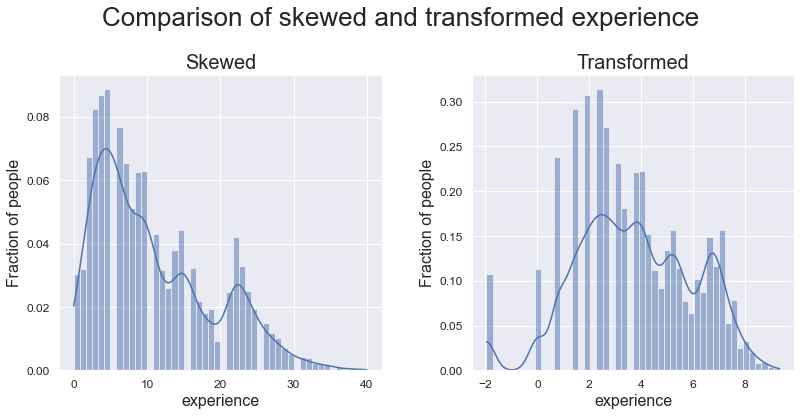

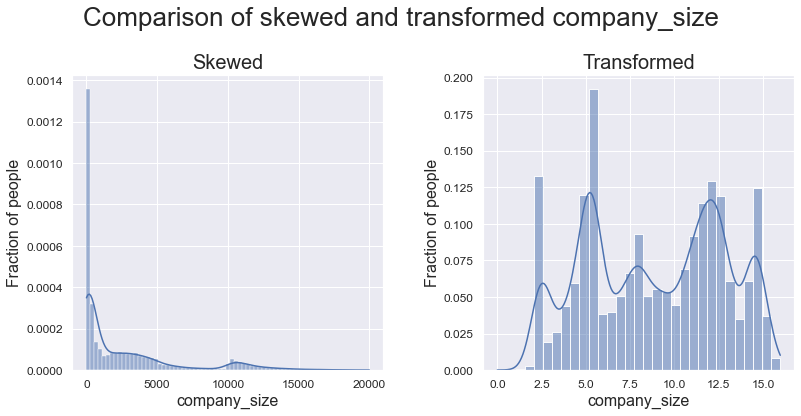

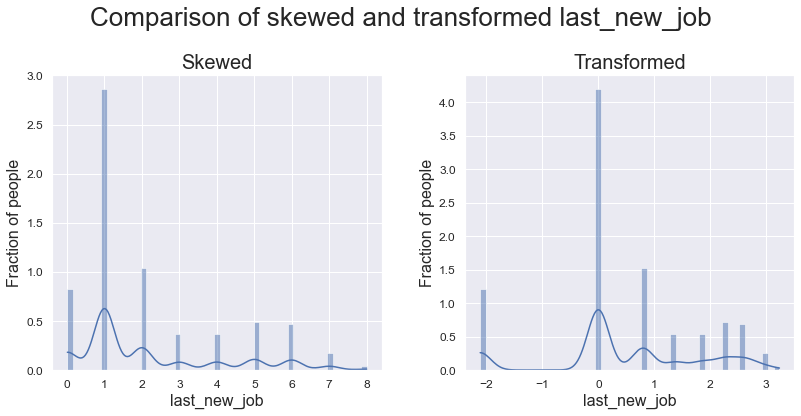

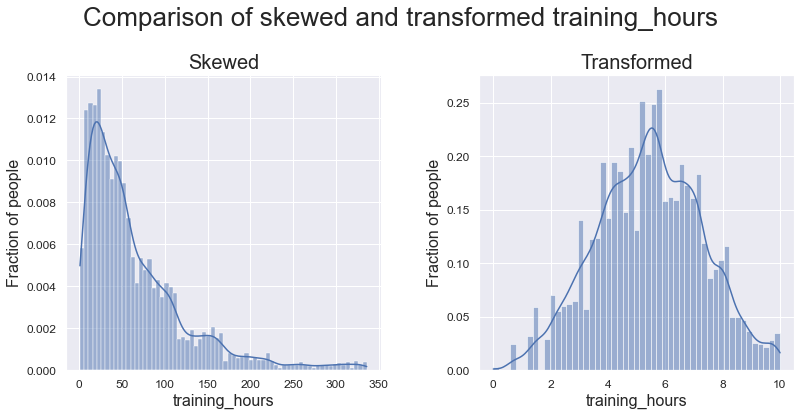

In [61]:
skewed = ["city_development_index", "experience", "company_size", "last_new_job", "training_hours"]

for ind, feature in enumerate(skewed):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Comparison of skewed and transformed {feature}", fontsize=26, y=1.02)
    
    sb.histplot(df[feature], stat="density", kde=True, ax=axs[0])
    (mu1, sigma1) = norm.fit(df[feature])

    df[feature], lam = boxcox(df[feature])
    
    sb.histplot(df[feature], stat="density", kde=True, ax=axs[1])
    (mu2, sigma2) = norm.fit(df[feature])
    
    axs[0].set_title("Skewed", fontsize=20)
    axs[1].set_title("Transformed", fontsize=20)
    for ind, ax in enumerate(axs.flat):
        ax.set_xlabel(feature, fontsize=16)
        ax.set_ylabel("Fraction of people", fontsize=16)
        ax.tick_params(labelsize=12)

    fig.tight_layout(pad=4)
    
    print(f"{feature} \n \t Pre-transformation: mu = {mu1}, sigma = {sigma1} \n",
          f"\t Post-transformation: mu = {mu2}, sigma = {sigma2} \n")

In [64]:
df_test.drop(columns=["enrollee_id", "city", "enrolled_university"], inplace=True)
df_test["relevent_experience"].replace({"Has relevent experience": "Has relevant experience", 
                                        "No relevent experience": "No relevant experience"}, inplace=True)
df_test["experience"] = df_test["experience"].replace({"<1": 0.01, ">20": 21}).astype("float").apply(exp_d, args=("experience",))
df_test["last_new_job"] = df_test["last_new_job"].replace({"never": 0.01, ">4": 5}).astype("float").apply(exp_d, args=("last_new_job",))
df_test["relevent_experience"] = df_test["relevent_experience"].replace({"No relevant experience": 0, "Has relevant experience": 1})

df_test["company_size"] = df_test["company_size"].replace({"10/49": "10-49"}).apply(exp_d_c_size)
m = df_test["company_size"].mean()
df_test["company_size"] = df_test["company_size"].apply(fill_na_c_size, args=(m, ))

df_test.loc[df_test["major_discipline"].isnull(), "major_discipline"] = df_test.loc[df_test["major_discipline"].isnull(), "education_level"].apply(map_func)

gender_dist = find_dist(df_test["gender"])
comp_type_dist = find_dist(df_test["company_type"])

df_test.loc[df_test["gender"].isnull(), "gender"] = df_test.loc[df_test["gender"].isnull(), "gender"].apply(fill_cat, args=(gender_dist, ))
df_test.loc[df_test["company_type"].isnull(), "company_type"] = df_test.loc[df_test["company_type"].isnull(), "company_type"].apply(fill_cat, args=(comp_type_dist, ))

df_test.dropna(inplace=True)

df_test = pd.get_dummies(data=df_test, drop_first=True)

In [65]:
skewed = ["city_development_index", "experience", "company_size", "last_new_job", "training_hours"]

for ind, feature in enumerate(skewed):
    (mu1, sigma1) = norm.fit(df_test[feature])
    df_test[feature], lam = boxcox(df_test[feature])
    (mu2, sigma2) = norm.fit(df_test[feature])

In [62]:
# Due to huge inequalities among the target variable, the models found it 
# easier to just predict NO almost every time
    # Therefore, decision has been made to only use a sample of 9014 people 
    # (double the number of positively answering people),
    # where all 4507 positively answering people and 4507 random samples will be chosen (=undersampling)
        # This cherry picking results in quite a big bias and also increases the impact
        # of randomness on this analysis, meaning that models will have different results every time
        # the code is ran
        # However, it is still much better than having models that just answer NO for each row
# The +- 1:3 ratio remains unchanged for the test dataset, which might result in higher inaccuracies, 
# but should also lower the bias of the models

# Due to this, our baseline model can bo chosen as the one that always picks NO
    # Therefore its accuracy is number of 0s divided by number of entries -> 0.75

In [63]:
len(df[df["target"] == 0])/len(df)

0.7531357835350825

In [99]:
# First approach - randomly under-sample to reach 1:1 ratio

sub_df1 = df[df["target"] == 1]
sub_df2 = df[df["target"] == 0].sample(4507)
df0 = sub_df1.append(sub_df2)

df0 = df0.sample(frac=1).assign(intercept=1)
df_test0 = df_test.sample(frac=1).assign(intercept=1)

train_X = df0.drop("target", axis=1)
train_y = df0["target"]
val_X = df_test0.drop("target", axis=1)
val_y = df_test0["target"]

In [100]:
# Second approach - random over-sampling using imblearn to reach 1:1 ratio

ros = RandomOverSampler()

df0 = df.sample(frac=1).assign(intercept=1)
df_test0 = df_test.sample(frac=1).assign(intercept=1)

train_X, train_y = ros.fit_resample(df0.drop("target", axis=1), df0.target)

In [ ]:
# Note - possible third approach - let the target variable be imbalanced
    # Results in models mostly predicting 0, which results in quite high accuracy but
    # very little use-case

<h2>Actual model creation</h2>

In [ ]:
# Note - all of the following code could be automated and therefore shortened by a lot
    # Not necessary for the purpose of this analysis, which is more about gaining insight into the data
    # rather than about manufacturing succesful algorithms

<h3>Logistic Regression</h3>

In [69]:
# Logistic regression is heavily hit with very little correlated data in terms of target variable
# As we have many of these, it will probably be very necessary to drop some columns based on their impact

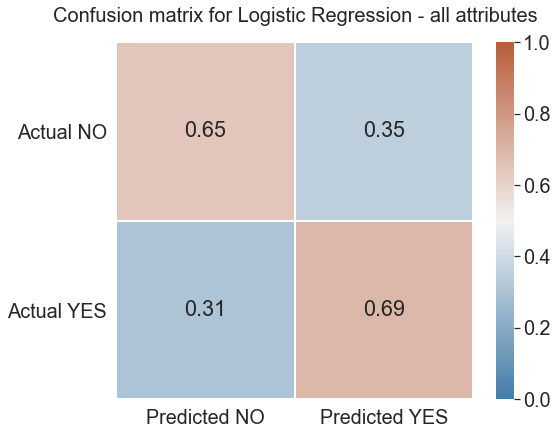

In [106]:
lor = LogisticRegression(n_jobs=-1)

lor.fit(scale(train_X), train_y)
lor_preds = lor.predict(scale(val_X))

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, lor_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Logistic Regression - all attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

In [107]:
logit = sm.Logit(train_y, train_X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.605000
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                27500
Model:                          Logit   Df Residuals:                    27477
Method:                           MLE   Df Model:                           22
Date:                Fri, 18 Jun 2021   Pseudo R-squ.:                  0.1272
Time:                        13:14:15   Log-Likelihood:                -16638.
converged:                       True   LL-Null:                       -19062.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
city_development_index             -17.8259      0.372    -47.973      0.000     -18.554     -17.098
relevent_experience                 -0.6226      0.033    -18.593      0.000      -0.688      -0.557
experience                          -0.0731      0.007    -10.160      0.000      -0.087      -0.059
company_size                         0.0773      0.004     20.748      0.000       0.070       0.085
last_new_job                         0.0436      0.011      3.840      0.000       0.021       0.066
training_hours                      -0.0168      0.007     -2.351      0.019      -0.031      -0.003
gender_Male                         -0.1853      0.047     -3.951      0.000      -0.277      -0.093
gender_Other                         0.0200      0.125      0.160      0.873      -0.224       0.264
education_level_High School         -0.1443   2.27e+06  -6.35e-08      1.000   -4.46e+06    4.46e+06
education_level_Masters             -0.2813      0.033     -8.638      0.000      -0.345      -0.217
education_level_Phd                 -0.5964      0.102     -5.848      0.000      -0.796      -0.397
education_level_Primary School      -0.7506   2.27e+06   -3.3e-07      1.000   -4.46e+06    4.46e+06
major_discipline_Business Degree     0.0255      0.147      0.174      0.862      -0.262       0.313
major_discipline_Humanities         -0.2202      0.132     -1.672      0.095      -0.478       0.038
major_discipline_No Major           -0.2599      0.164     -1.582      0.114      -0.582       0.062
major_discipline_No university      -0.8949   2.27e+06  -3.94e-07      1.000   -4.46e+06    4.46e+06
major_discipline_Other              -0.2729      0.145     -1.881      0.060      -0.557       0.011
major_discipline_STEM               -0.2407      0.113     -2.136      0.033      -0.462      -0.020
company_type_Funded Startup         -0.2848      0.078     -3.660      0.000      -0.437      -0.132
company_type_NGO                    -0.3270      0.090     -3.638      0.000      -0.503      -0.151
company_type_Other                  -0.1495      0.154     -0.969      0.333      -0.452       0.153
company_type_Public Sector          -0.1140      0.078     -1.452      0.147      -0.268       0.040
company_type_Pvt Ltd                -0.3360      0.063     -5.314      0.000      -0.460      -0.212
intercept                           -0.8926      0.147     -6.086      0.000      -1.180      -0.605
====================================================================================================
"""

In [111]:
# If we assume alpha to be 0.05, we can drop columns with (P>|z|) > alpha

to_drop = ["training_hours", "company_size", "last_new_job", "gender_Other", 
           "education_level_High School", "education_level_Phd", 
           "major_discipline_Business Degree", "major_discipline_Humanities", 
           "major_discipline_No Major", "major_discipline_Other", "major_discipline_STEM", 
           "company_type_Funded Startup", "company_type_NGO", "company_type_Other", 
           "company_type_Public Sector", "company_type_Pvt Ltd"]

train_X2 = train_X.drop(columns=to_drop)
val_X2 = val_X.drop(columns=to_drop)

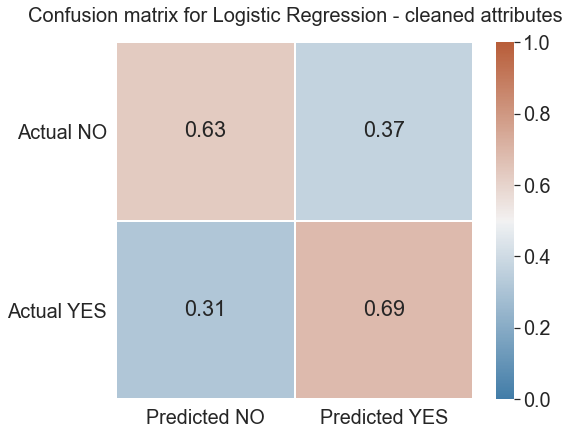

In [112]:
lor = LogisticRegression(n_jobs=-1)

lor.fit(scale(train_X2), train_y)
lor_preds = lor.predict(scale(val_X2))

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, lor_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Logistic Regression - cleaned attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h3>Random Forest</h3>

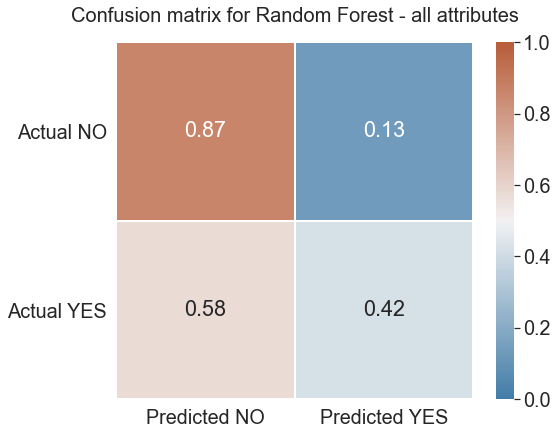

In [134]:
rfc = RandomForestClassifier(n_estimators=250, n_jobs=-1, criterion="entropy")

rfc.fit(train_X, train_y)
rfc_preds = rfc.predict(val_X)

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, rfc_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Random Forest - all attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

In [135]:
importances = list(rfc.feature_importances_)
importances = pd.DataFrame([round(i, 3) for i in importances], index=train_X.columns)
importances.sort_values(by=0)

,0
intercept,0.000
company_type_Other,0.002
major_discipline_No Major,0.002
education_level_Primary School,0.002
gender_Other,0.003
education_level_High School,0.003
major_discipline_Business Degree,0.003
major_discipline_Other,0.003
major_discipline_Humanities,0.004
education_level_Phd,0.004


In [148]:
# We can drop columns with importance under 0.01
to_drop = importances[importances[0] < 0.01].index.tolist()

train_X3 = train_X.drop(columns=to_drop)
val_X3 = val_X.drop(columns=to_drop)

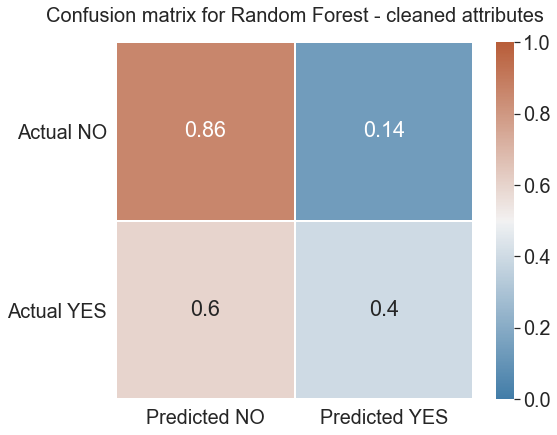

In [149]:
rfc = RandomForestClassifier(n_estimators=250, n_jobs=-1, criterion="entropy")

rfc.fit(train_X3, train_y)
rfc_preds = rfc.predict(val_X3)

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, rfc_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Random Forest - cleaned attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h3>K Nearest Neighbors</h3>

In [ ]:
# This configuration of hyperparameters (mainly the used data)
# has been chosen based on a lot of testing

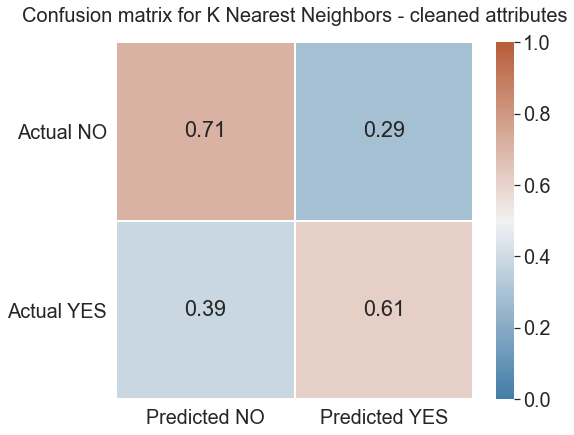

In [117]:
knn = KNeighborsClassifier(19, n_jobs=-1)

knn.fit(scale(train_X2), train_y)
knn_preds = knn.predict(scale(val_X2))

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, knn_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for K Nearest Neighbors - cleaned attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h3>Support Vector Machine</h3>

In [ ]:
# This configuration of hyperparameters (mainly the used data)
# has been chosen based on a lot of testing

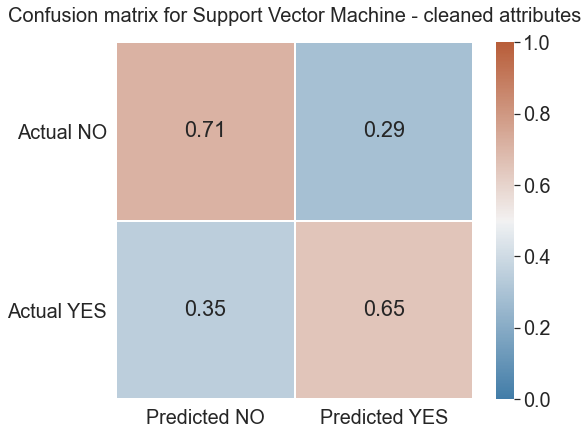

In [118]:
svm = SVC(C=7)

svm.fit(scale(train_X2), train_y)
svm_preds = svm.predict(scale(val_X2))

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, svm_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Support Vector Machine - cleaned attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h3>Histogram Gradient Boosting</h3>

In [ ]:
# This configuration of hyperparameters (mainly the used data)
# has been chosen based on a lot of testing

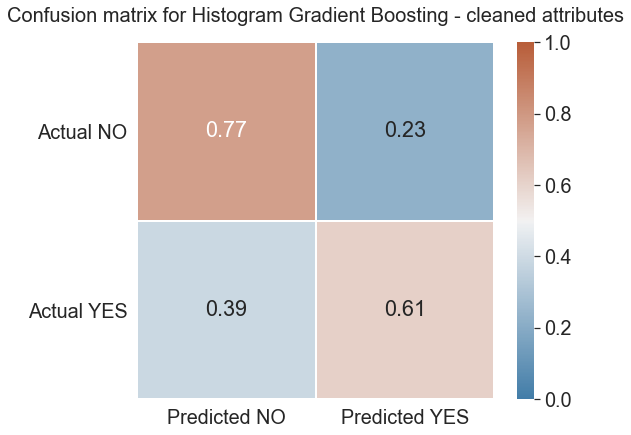

In [128]:
hgbc = HistGradientBoostingClassifier(learning_rate=0.05, loss="binary_crossentropy",
                                      max_iter=10, max_leaf_nodes=10, scoring="loss")

hgbc.fit(scale(train_X2), train_y)
hgbc_preds = hgbc.predict(scale(val_X2))

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(val_y, hgbc_preds, normalize="true"),
          vmin=0, vmax=1, cmap=cmap, square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted NO", "Predicted YES"],
          yticklabels=["Actual NO", "Actual YES"])

plt.title("Confusion matrix for Histogram Gradient Boosting - cleaned attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

In [150]:
# Since we have chosen the over-sampling approach and our target variable is now balanced,
# acuracy is actually a relevant metric 
    # would not be the case with the original imbalanced dataset

print("Baseline: 0.75", 
      "\nLogistic Regression: ", accuracy_score(val_y, lor_preds),
      "\nRandom Forrest: ", accuracy_score(val_y, rfc_preds),
      "\nK-Nearest Neighbors: ", accuracy_score(val_y, knn_preds),
      "\nSupport Vector Machine: ", accuracy_score(val_y, svm_preds),
      "\nHistogram Gradient Boosting: ", accuracy_score(val_y, hgbc_preds))

Baseline: 0.75 
Logistic Regression:  0.6472317491425772 
Random Forrest:  0.7364037236648702 
K-Nearest Neighbors:  0.6874081332680059 
Support Vector Machine:  0.6952474277315042 
Histogram Gradient Boosting:  0.7305242528172464


<h1>Possible next steps</h1>

    • Automate the model creation/selection process
    • Select the features much more carefully
    • Pay more attention to model hyperparameters tuning
    • Under some dubious assumptions and data from the internet we could add few features that the company did not collect
        • These would be for instance age, years of relevant experience
    • Fill the missing data based on clustering algorithms rather than randomness and distributions
    • Change the target variable to training hours and try to predict this value for each participant
        • A new value based on both of these columns could be created
            • One that would consider that recruits with most training hours who do not change their job are extra-costly